In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

sys.path.append(os.path.abspath('../..'))

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
import joblib

In [4]:
from hit_finding.constants import *
from hit_finding.metrics import *
from learning_tabular.preprocessing import list_columns

# Compare Hits Reproduction

In [5]:
zscores = extract_scores_from_all(extract_score, threshold=4)
joined = pd.concat(zscores.values())
joined.shape

...................................

(11197, 18)

In [33]:
field = 'ALL_map'

In [34]:
compounds_cnt = joined.query(f'{field} >= 0').index.get_level_values(1).value_counts()
compounds_cnt

BRD-K50417881-003-05-9    3
BRD-K47635719-001-03-9    3
BRD-K47328134-001-02-0    3
BRD-K47337578-034-01-7    3
BRD-K47407372-001-04-9    3
                         ..
BRD-K33933950-001-01-6    1
BRD-K33760789-001-02-8    1
BRD-K33755346-001-01-6    1
BRD-K33576455-001-01-3    1
BRD-M98484762-001-01-8    1
Name: Metadata_broad_sample, Length: 9599, dtype: int64

In [35]:
dup_compounds = (compounds_cnt[compounds_cnt > 1]).index
dup_compounds

Index(['BRD-K50417881-003-05-9', 'BRD-K47635719-001-03-9',
       'BRD-K47328134-001-02-0', 'BRD-K47337578-034-01-7',
       'BRD-K47407372-001-04-9', 'BRD-K47467075-001-02-7',
       'BRD-K47598052-001-04-2', 'BRD-K47608922-001-02-1',
       'BRD-K47631482-003-02-1', 'BRD-K47639036-003-03-3',
       ...
       'BRD-A15530910-001-01-3', 'BRD-A15454510-001-02-8',
       'BRD-A15435692-003-01-5', 'BRD-A15415227-003-01-1',
       'BRD-A15070535-323-02-1', 'BRD-A15034104-002-03-6',
       'BRD-A14574269-051-01-4', 'BRD-A44863528-001-04-1',
       'BRD-A35033682-001-01-0', 'BRD-A00267231-001-01-1'],
      dtype='object', length=1279)

In [36]:
replicates = joined[joined.index.isin(dup_compounds,1)]
replicates.shape

(2877, 18)

In [37]:
cpds = replicates.index.get_level_values(1).unique()

In [38]:
cpds

Index(['BRD-A00100033-001-04-8', 'BRD-A00267231-001-01-1',
       'BRD-A00327403-103-01-9', 'BRD-A00520476-001-03-3',
       'BRD-A00827783-001-04-8', 'BRD-A00993607-003-04-8',
       'BRD-A01078468-001-04-9', 'BRD-A01295252-001-01-5',
       'BRD-A01320529-001-05-9', 'BRD-A01493904-003-02-2',
       ...
       'BRD-K97048125-001-01-6', 'BRD-K97196700-001-01-6',
       'BRD-K97585006-001-01-1', 'BRD-K98036459-001-01-6',
       'BRD-K98668154-001-01-4', 'BRD-K98956791-001-01-2',
       'BRD-K99149118-001-01-9', 'BRD-K99547414-001-01-5',
       'BRD-K99615821-001-01-7', 'BRD-K99647384-001-01-9'],
      dtype='object', name='Metadata_broad_sample', length=1279)

In [39]:
replicates.index.get_level_values(1).value_counts().value_counts()

2    960
3    319
Name: Metadata_broad_sample, dtype: int64

In [40]:
def get_median_score(cpds_list, df):
    """
    This function calculates the median score for each compound based on its replicates
    """
    
    cpds_median_score = {}
    for cpd in cpds_list:
        cpd_replicates = df[df.index.isin([cpd], 1)].copy()
        cor_mat = cpd_replicates.astype('float64').T.corr(method = 'pearson').values
        if len(cor_mat) == 1:
            median_val = 1
        else:
            median_val = np.median(cor_mat[np.triu_indices(len(cor_mat), k = 1)])
            
        cpds_median_score[cpd] = median_val
        
    return cpds_median_score

In [41]:
cpds_med_score = {}
for method in ['map', 'raw']:
    cur = replicates.filter(regex=f'_{method}$')
    cpds_med_score[method] = get_median_score(cpds, cur)

In [42]:
cpds_score_df = pd.DataFrame(cpds_med_score)
cpds_score_df.shape

(1279, 2)

In [43]:
def drop_cpds_with_null(df):
    """
    This function drop compounds with median scores of 1 
    or null values in any of the dose points (1-6)
    """
    cpds_with_null = []
    for cpd in df.index:
        if any(df.loc[cpd] == 1) | any(df.loc[cpd].isnull()):
            cpds_with_null.append(cpd)
    df.drop(cpds_with_null, axis = 0, inplace = True)
    
    return df

In [44]:
drop_cpds_with_null(cpds_score_df)
cpds_score_df.shape

(84, 2)

In [45]:
cpds_score_df

,map,raw
BRD-A00100033-001-04-8,0.679221,-0.510316
BRD-A04231641-003-01-3,-0.965006,-0.838505
BRD-A06276885-003-01-1,-0.779965,-0.931328
BRD-A06352508-001-02-9,-0.863700,-0.152323
BRD-A15914070-001-01-5,-0.460837,-0.858781
...,...,...
BRD-K74428993-001-01-6,0.746601,0.085827
BRD-K76624532-001-01-6,-0.249922,0.250068
BRD-K76665741-001-01-6,0.943243,0.163728
BRD-K81666293-001-01-9,0.232643,0.272267


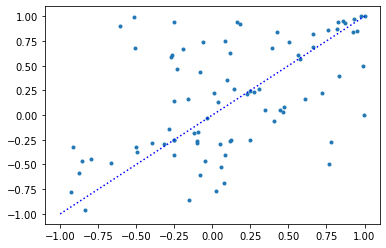

In [46]:
_ = plt.plot(cpds_score_df['raw'], cpds_score_df['map'], '.')
_ = plt.plot([-1,1], [-1,1], 'b:')

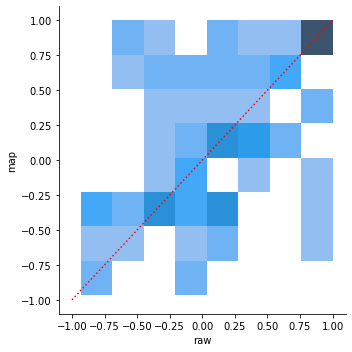

In [47]:
sns.displot(x=cpds_score_df['raw'], y=cpds_score_df['map'])
_ = plt.plot([-1,1], [-1,1], 'r:')

## with_all_zscores

In [5]:
cpd_map = pd.concat([load_pure_zscores(p_name, raw=False) for _, p_name in files])
cpd_raw = pd.concat([load_pure_zscores(p_name, raw=True) for _, p_name in files])
cpd_raw1to1 = pd.concat([load_pure_zscores(p_name, raw=True, inter_channel=False) for _, p_name in files])

cpd_raw.drop(columns=[c for c in cpd_raw.columns if c not in cpd_map.columns], inplace=True)

cpd_map.shape, cpd_raw.shape, cpd_raw1to1.shape

((13439, 414), (13439, 414), (13439, 414))

In [6]:
cpd_map_trt = cpd_map.query('Metadata_ASSAY_WELL_ROLE == "treated"')
cpd_raw_trt = cpd_raw.query('Metadata_ASSAY_WELL_ROLE == "treated"')
cpd_raw1to1_trt = cpd_raw1to1.query('Metadata_ASSAY_WELL_ROLE == "treated"')

cpd_map_ctl = cpd_map.query('Metadata_ASSAY_WELL_ROLE == "mock"')
cpd_raw_ctl = cpd_raw.query('Metadata_ASSAY_WELL_ROLE == "mock"')
cpd_raw1to1_ctl = cpd_raw1to1.query('Metadata_ASSAY_WELL_ROLE == "mock"')

#### Try simplify

In [7]:
def get_median_score(cpds_list, df):
    """
    This function calculates the median score for each compound based on its replicates
    """
    
    cpds_median_score = {}
    for cpd in cpds_list:
        cpd_replicates = df[df.index.isin([cpd], 2)].copy()
        cor_mat = cpd_replicates.astype('float64').T.corr(method = 'pearson').values
        if len(cor_mat) == 1:
            median_val = 1
        else:
            median_val = np.median(cor_mat[np.triu_indices(len(cor_mat), k = 1)])
            
        cpds_median_score[cpd] = median_val
        
    return cpds_median_score


def drop_cpds_with_null(df):
    """
    This function drop compounds with median scores of 1 
    or null values in any of the dose points (1-6)
    """
    cpds_with_null = []
    for cpd in df.index:
        if any(df.loc[cpd] == 1) | any(df.loc[cpd].isnull()):
            cpds_with_null.append(cpd)
    df.drop(cpds_with_null, axis = 0, inplace = True)
    
    return df


def get_replicates_score(cpd_df, fields=None):
    if not fields:
        fields = cpd_df.columns
        
    compounds_cnt = cpd_df.index.get_level_values(2).value_counts()
    dup_compounds = (compounds_cnt[compounds_cnt > 1]).index
    replicates = cpd_df[cpd_df.index.isin(dup_compounds, 2)]
    cpds = replicates.index.get_level_values(2).unique()
#     print(replicates.index.get_level_values(2).value_counts().value_counts())
    
    cpds_score_df = get_median_score(cpds, replicates[fields])
    
    return cpds_score_df

In [8]:
cpds_med_score = {f'{m}_{t}': get_replicates_score(eval(f'cpd_{m}_{t}'))
                  for m in ['map', 'raw', 'raw1to1']
                  for t in ['trt', 'ctl']
                 }

In [39]:
cpds_score_df_trt = pd.DataFrame({k[:-4]: v for k, v in cpds_med_score.items() if 'trt' in k})
cpds_score_df_ctl = pd.DataFrame({k[:-4]: v for k, v in cpds_med_score.items() if 'ctl' in k})

cpds_score_df_trt.shape, cpds_score_df_ctl.shape

((1279, 3), (1, 3))

In [41]:
drop_cpds_with_null(cpds_score_df_trt)
cpds_score_df_trt.shape

(1279, 3)

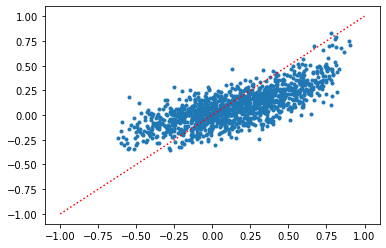

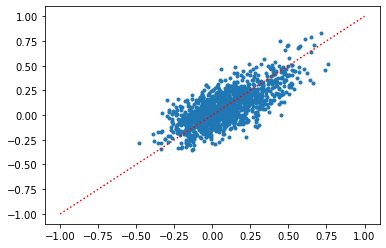

In [45]:
for b in ['raw', 'raw1to1']:
    _ = plt.plot(cpds_score_df_trt[b], cpds_score_df_trt['map'], '.')
    _ = plt.plot([-1,1], [-1,1], 'r:')
    plt.show()

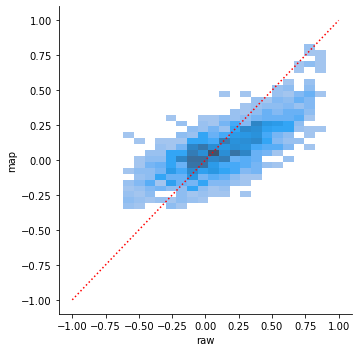

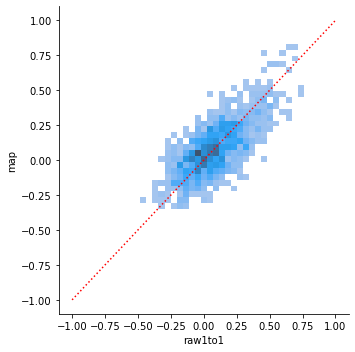

In [42]:
for b in ['raw', 'raw1to1']:
    sns.displot(x=cpds_score_df_trt[b], y=cpds_score_df_trt['map'])
    _ = plt.plot([-1,1], [-1,1], 'r:')
    plt.show()

In [46]:
result = cpds_score_df_trt.rename_axis('Metadata_broad_sample').join(joined.groupby('Metadata_broad_sample').mean(), how='inner')
result

,map,raw,raw1to1,AGP_map,DNA_map,ER_map,Mito_map,RNA_map,ALL_map,AGP_raw,...,ER_raw,Mito_raw,RNA_raw,ALL_raw,AGP_raw1to1,DNA_raw1to1,ER_raw1to1,Mito_raw1to1,RNA_raw1to1,ALL_raw1to1
Metadata_broad_sample,,,,,,,,,,,,,,,,,,,,,
BRD-A00100033-001-04-8,-0.109992,-0.157684,0.142699,0.005814,0.107143,0.005814,0.000000,0.081395,0.037440,0.005814,...,0.029070,0.005814,0.122093,0.053140,0.005814,0.1,0.011628,0.000000,0.110465,0.043478
BRD-A00267231-001-01-1,-0.160473,-0.098811,-0.124243,0.017442,0.000000,0.000000,0.005814,0.046512,0.014493,0.000000,...,0.000000,0.000000,0.005814,0.001208,0.000000,0.0,0.000000,0.000000,0.005814,0.001208
BRD-A00327403-103-01-9,-0.042059,-0.261932,-0.011834,0.000000,0.000000,0.000000,0.000000,0.005814,0.001208,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
BRD-A00520476-001-03-3,-0.029160,-0.346886,-0.118952,0.005814,0.000000,0.000000,0.000000,0.000000,0.001208,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
BRD-A00827783-001-04-8,0.192211,0.139913,0.108053,0.000000,0.000000,0.000000,0.000000,0.005814,0.001208,0.000000,...,0.005814,0.000000,0.005814,0.002415,0.000000,0.0,0.005814,0.000000,0.005814,0.002415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BRD-K98956791-001-01-2,-0.071283,-0.093743,-0.098855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
BRD-K99149118-001-01-9,0.009340,0.135657,-0.056558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
BRD-K99547414-001-01-5,0.009022,-0.301712,-0.232907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


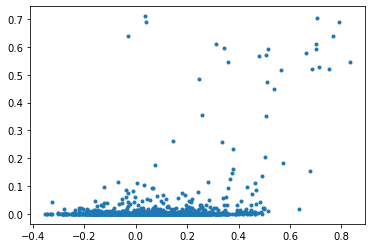

In [32]:
plt.plot(result['map'], result['ALL_map'], '.')

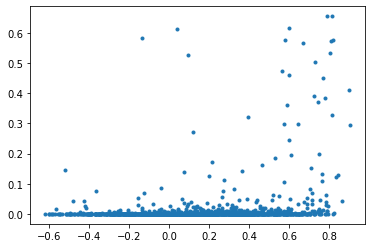

In [33]:
plt.plot(result['raw'], result['ALL_raw'], '.')

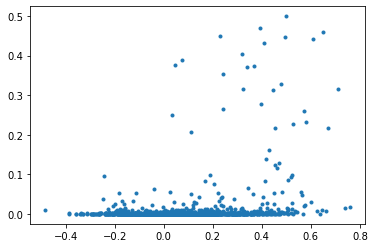

In [47]:
plt.plot(result['raw1to1'], result['ALL_raw1to1'], '.')

In [49]:
xedges = [-1, -0.5, -0.25, 0, 0.25, 0.5, 1]
yedges = [0, 0.2, 0.5, 0.8, 1]
# xedges = np.arange(-1,1.1,0.2)
# yedges = np.arange(0,1.01,0.1)

bins = (xedges, yedges)

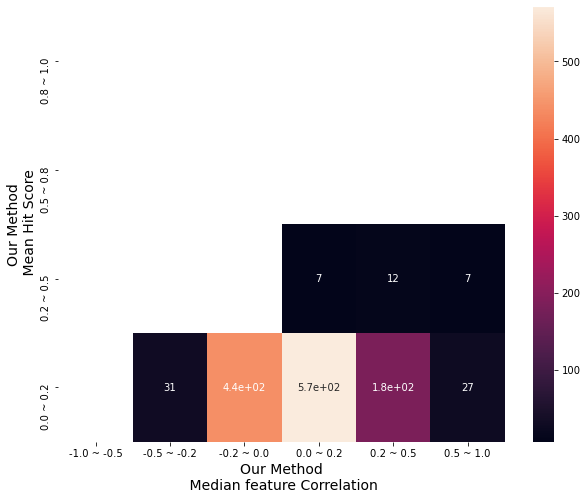

In [50]:
method = 'raw1to1'
H, xedges, yedges = np.histogram2d(x=result[f'{method}'], y=result[f'ALL_{method}'], bins=bins)
fig, ax = plt.subplots(figsize=(10,8))
_ = sns.heatmap(np.flip(H.T,axis=0),
            annot=True,
            xticklabels=[f'{l1:.1f} ~ {l2:.1f}' for l1, l2 in zip(xedges, xedges[1:])],
            yticklabels=[f'{l1:.1f} ~ {l2:.1f}' for l2, l1 in zip(np.flip(yedges), np.flip(yedges)[1:])],
                mask = np.flip(H.T,axis=0)==0,
           ax=ax)
_ = ax.set_xlabel('Our Method\n Median feature Correlation', fontsize=14)
_ = ax.set_ylabel('Our Method\n Mean Hit Score', fontsize=14)

### Control Distribution

In [16]:
plates = list(cpd_map_ctl.index.get_level_values(0).unique())

In [55]:
def get_corr_between_plates(df, plates):
    all_corrs = {}

    for plate in tqdm(plates):
        all_corrs[plate] = []
        for rowi, row in df.loc[plate].iterrows():
            corrs = [
                df.loc[p].astype('float64').corrwith(row, axis=1, method = 'pearson').values
                for p in plates if p != plate
            ]
            all_corrs[plate].append(np.concatenate(corrs))

        all_corrs[plate] = np.concatenate(all_corrs[plate])
        
    return all_corrs

In [ ]:
map_ctl_dist = get_corr_between_plates(cpd_map_ctl, plates)
raw_ctl_dist = get_corr_between_plates(cpd_raw_ctl, plates)
raw1to1_ctl_dist = get_corr_between_plates(cpd_raw1to1_ctl, plates)

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
import joblib
joblib.dump(map_ctl_dist, '/home/naorko/map_ctl_dist.sav')
joblib.dump(raw_ctl_dist, '/home/naorko/raw_ctl_dist.sav')
joblib.dump(raw1to1_ctl_dist, '/home/naorko/raw1to1_ctl_dist.sav')

In [ ]:
import os
job_cancel_str="scancel " + os.environ['SLURM_JOBID']
os.system(job_cancel_str)

In [5]:
map_ctl_dist = joblib.load('/home/naorko/map_ctl_dist.sav')
raw_ctl_dist = joblib.load('/home/naorko/raw_ctl_dist.sav')
raw1to1_ctl_dist = joblib.load('/home/naorko/raw1to1_ctl_dist.sav')

In [18]:
ctl_dist = pd.DataFrame({'Our Method': np.concatenate(list(map_ctl_dist.values())),
              'Statistical Baseline': np.concatenate(list(raw_ctl_dist.values())),
              'Autoencoder Baseline': np.concatenate(list(raw1to1_ctl_dist.values()))})

In [24]:
ctl_dist_df = ctl_dist.melt(value_name='Correlation', var_name='Method')
ctl_dist_df

,Method,Correlation
0,Our Method,-0.029383
1,Our Method,0.254342
2,Our Method,0.289396
3,Our Method,0.387565
4,Our Method,-0.134080
...,...,...
14648833,Autoencoder Baseline,0.185167
14648834,Autoencoder Baseline,0.049796
14648835,Autoencoder Baseline,-0.083062
14648836,Autoencoder Baseline,0.057085


<AxesSubplot:xlabel='Correlation', ylabel='Density'>

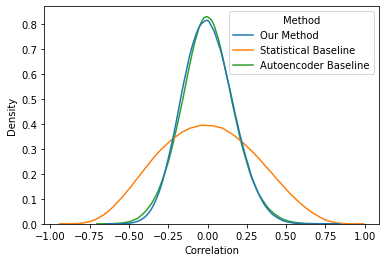

In [25]:
sns.kdeplot(data=ctl_dist_df, hue='Method', x='Correlation')

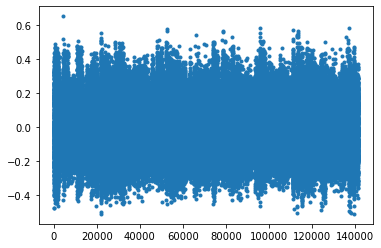

In [53]:
plt.plot(all_corrs[plate], '.')
plt.show()

## By Channel

In [52]:
_, _, cols_dict = list_columns(cpd_map)

In [53]:
cols_dict = {'ALL': [c for cs in cols_dict.values() for c in cs],
             **cols_dict}

In [ ]:
cpds_med_score_by_chan = {f'{m}_{t}': get_replicates_score(eval(f'cpd_{m}_{t}'))
                  for m in ['map', 'raw', 'raw1to1']
                  for t in ['trt', 'ctl']
                 }

In [59]:
cpds_med_score_by_chan = {
    **{f'{chan}_map': 
     get_replicates_score(cpd_map_trt, fields=chan_fields) for chan, chan_fields in cols_dict.items()},
    **{f'{chan}_raw': 
     get_replicates_score(cpd_raw_trt, fields=chan_fields) for chan, chan_fields in cols_dict.items()},
    **{f'{chan}_raw1to1': 
     get_replicates_score(cpd_raw1to1_trt, fields=chan_fields) for chan, chan_fields in cols_dict.items()}
}

2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_sample, dtype: int64
2    960
3    319
Name: Metadata_broad_s

In [60]:
cpds_med_score_by_chan_df = pd.DataFrame(cpds_med_score_by_chan)
cpds_med_score_by_chan_df

,ALL_map,AGP_map,DNA_map,ER_map,Mito_map,RNA_map,ALL_raw,AGP_raw,DNA_raw,ER_raw,Mito_raw,RNA_raw,ALL_raw1to1,AGP_raw1to1,DNA_raw1to1,ER_raw1to1,Mito_raw1to1,RNA_raw1to1
BRD-A00100033-001-04-8,-0.109992,-0.005620,-0.253483,-0.072452,-0.101222,-0.134122,-0.157684,0.007516,-0.577556,-0.033938,-0.435423,0.114637,0.142699,-0.156968,0.011399,0.181680,-0.082486,0.125631
BRD-A00267231-001-01-1,-0.160473,0.012525,-0.122398,-0.007871,-0.224019,-0.335753,-0.098811,0.031065,-0.405630,0.056356,-0.304325,0.100969,-0.124243,-0.381930,-0.170020,0.237990,-0.296485,0.008718
BRD-A00327403-103-01-9,-0.042059,-0.066618,0.205745,-0.175769,0.220095,-0.129723,-0.261932,-0.457811,-0.146423,-0.376083,0.036551,-0.270521,-0.011834,-0.067462,0.513728,-0.217614,-0.048320,-0.173463
BRD-A00520476-001-03-3,-0.029160,-0.257946,0.072644,-0.072024,0.224602,0.005058,-0.346886,-0.555994,-0.438898,-0.310536,-0.265016,-0.235695,-0.118952,-0.218784,-0.122520,-0.087126,-0.042123,-0.171417
BRD-A00827783-001-04-8,0.192211,0.113086,0.418614,0.428500,0.244163,0.036836,0.139913,0.035962,0.435592,0.147733,0.118639,-0.045322,0.108053,-0.038196,-0.053966,0.288882,0.256213,-0.036671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BRD-K98956791-001-01-2,-0.071283,-0.000067,-0.092324,0.029673,-0.013558,-0.304003,-0.093743,-0.178057,-0.288335,0.014044,-0.138618,-0.084974,-0.098855,0.059286,-0.416639,0.018240,-0.271790,-0.130368
BRD-K99149118-001-01-9,0.009340,0.041977,-0.131664,0.207623,-0.092806,0.151877,0.135657,-0.081719,0.666241,0.059642,0.031534,0.169051,-0.056558,-0.129689,0.208904,-0.055535,-0.374465,0.033899
BRD-K99547414-001-01-5,0.009022,0.076016,0.069050,-0.197153,-0.101958,0.020357,-0.301712,-0.547666,0.209485,-0.161910,-0.547488,-0.550342,-0.232907,-0.278890,-0.289605,-0.106558,-0.216257,-0.370220
BRD-K99615821-001-01-7,0.216896,0.494058,-0.455398,-0.190126,0.362280,0.242400,0.478038,0.347665,0.128577,0.009923,0.624234,0.649896,0.393250,0.172928,0.370132,0.248804,0.516216,0.322878


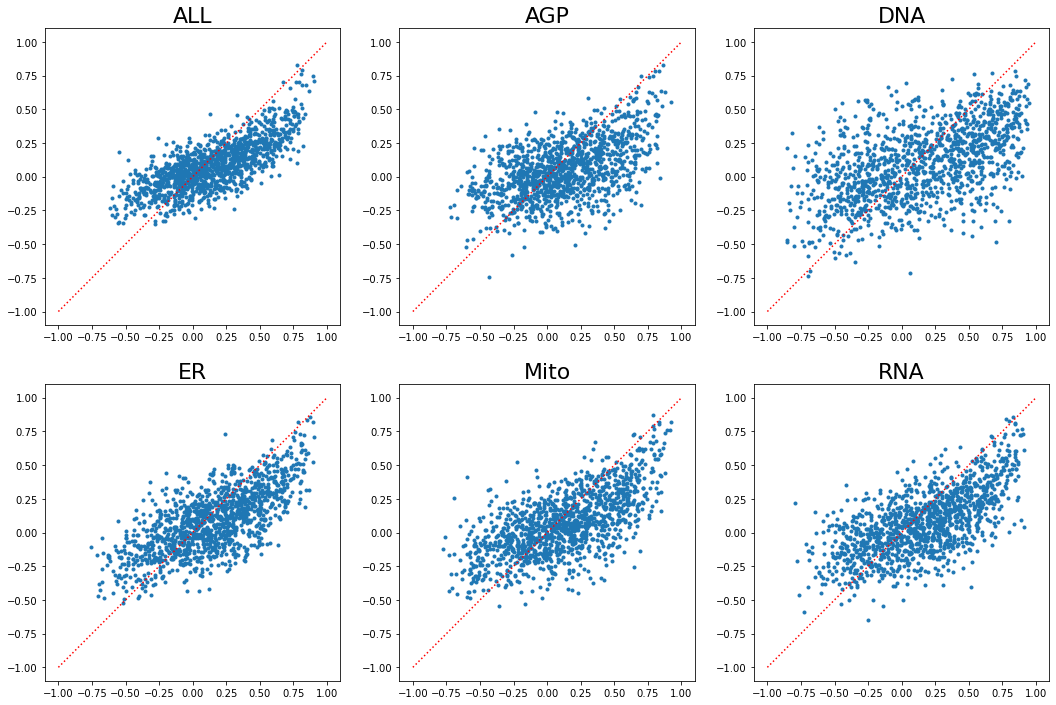

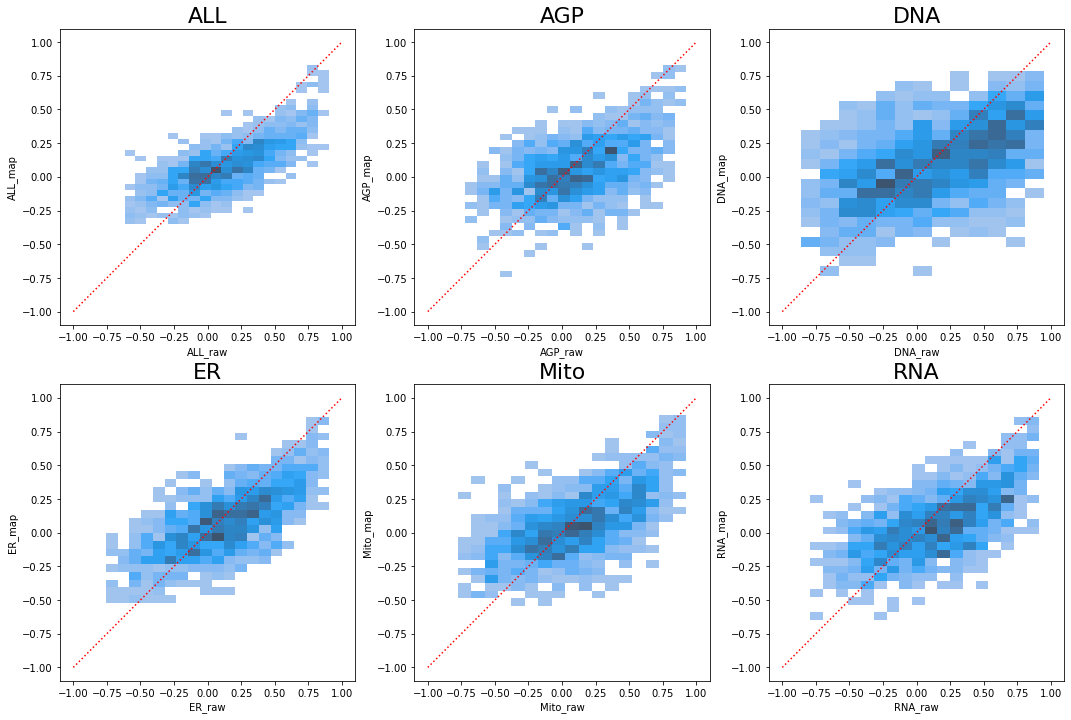

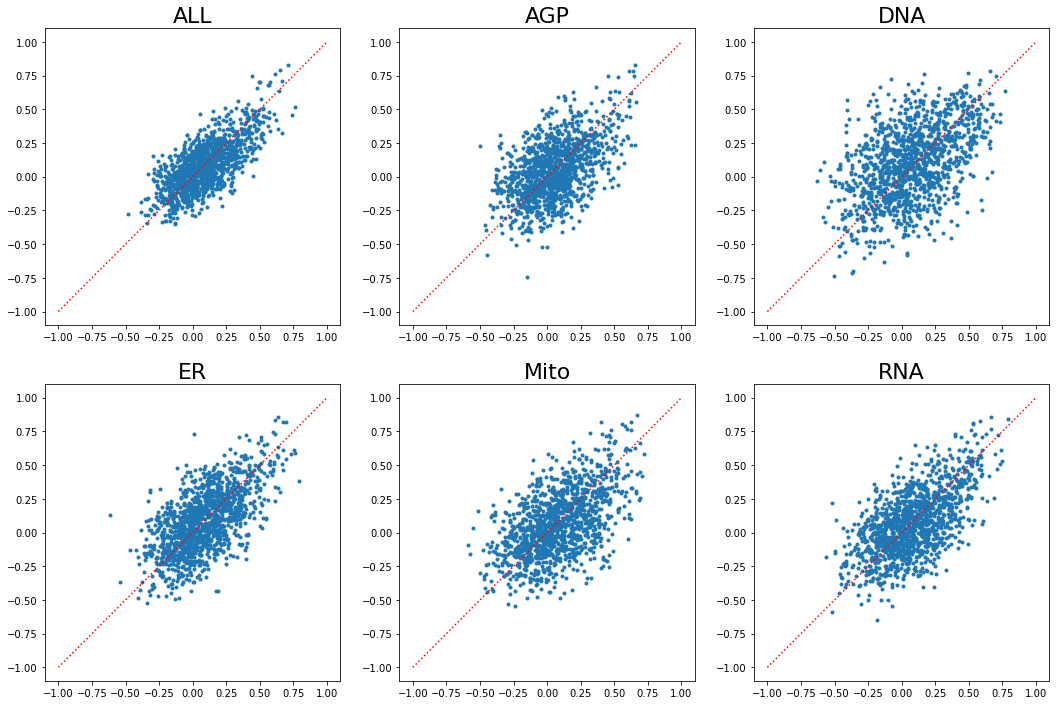

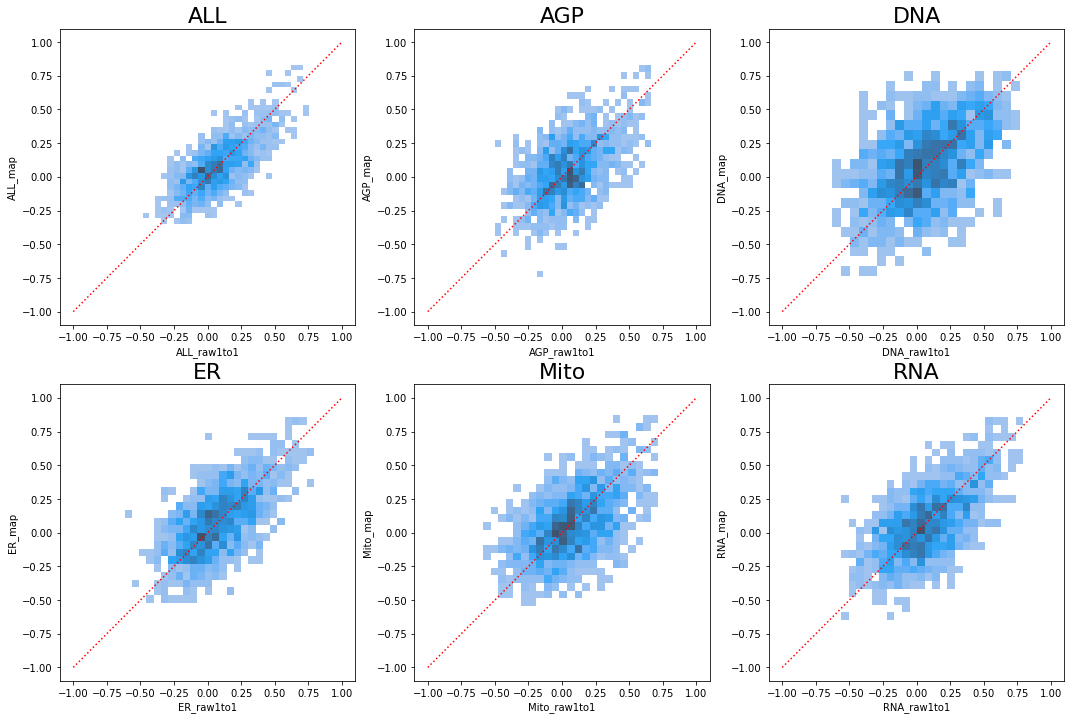

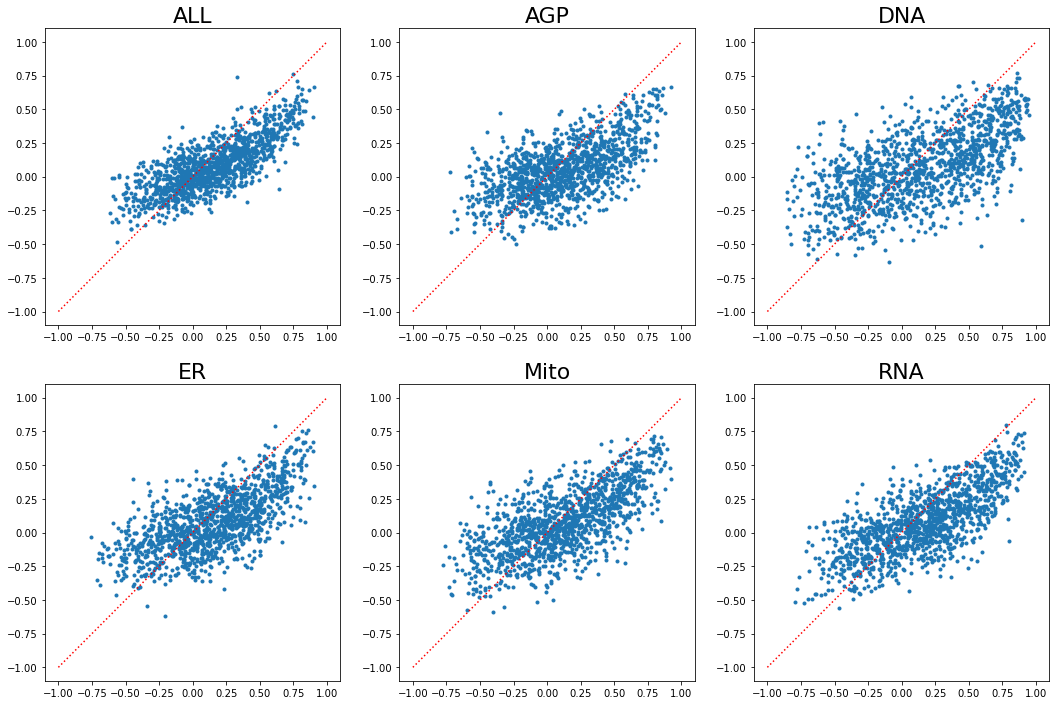

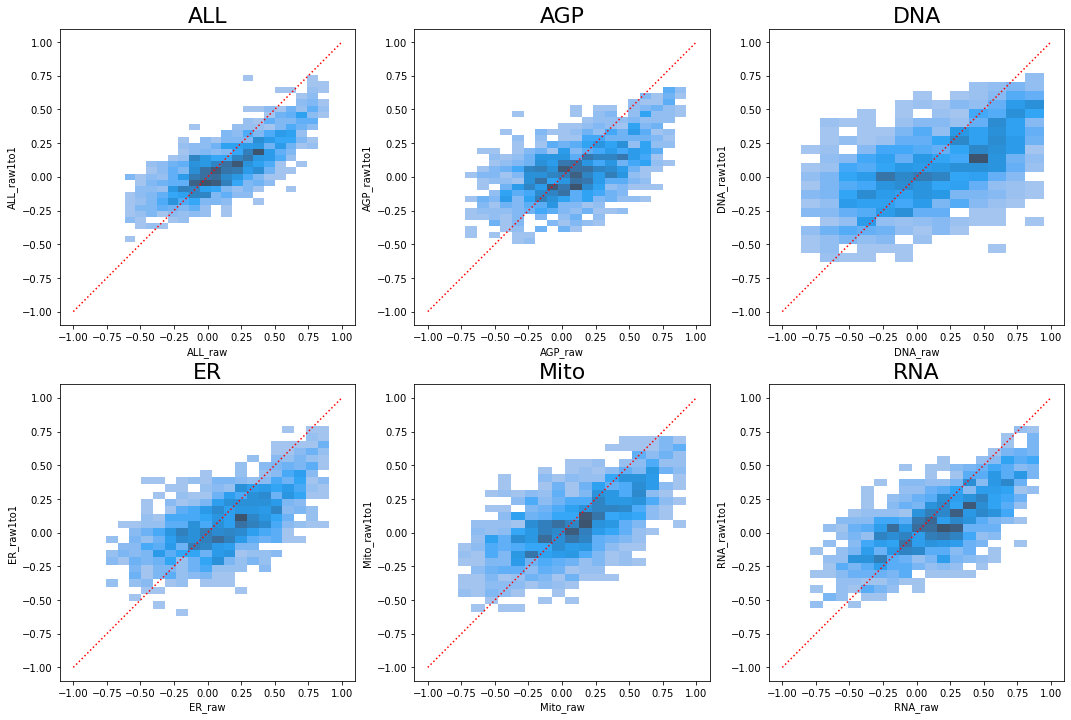

In [67]:
for bx, by in zip(['raw', 'raw1to1', 'raw'], ['map', 'map', 'raw1to1']):
    ncols=3
    fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(ncols*6, 2*6))

    for i, chan in enumerate(cols_dict.keys()):
        ax = axs[i//ncols, i%ncols]
        _ = ax.plot(cpds_med_score_by_chan_df[f'{chan}_{bx}'], cpds_med_score_by_chan_df[f'{chan}_{by}'], '.')
        _ = ax.plot([-1,1], [-1,1], 'r:')
        ax.set_title(chan, fontsize=22)
    plt.show()

    ncols=3
    fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(ncols*6, 2*6))

    for i, chan in enumerate(cols_dict.keys()):
        ax = axs[i//ncols, i%ncols]
        sns.histplot(x=cpds_med_score_by_chan_df[f'{chan}_{bx}'], y=cpds_med_score_by_chan_df[f'{chan}_{by}'], ax=ax)
        _ = ax.plot([-1,1], [-1,1], 'r:')
        ax.set_title(chan, fontsize=22)
    plt.show()

In [62]:
result_per_chan = cpds_med_score_by_chan_df.rename_axis('Metadata_broad_sample').join(
    joined.groupby('Metadata_broad_sample').mean(), how='inner', lsuffix='_corr', rsuffix='_hit')
result_per_chan

,ALL_map_corr,AGP_map_corr,DNA_map_corr,ER_map_corr,Mito_map_corr,RNA_map_corr,ALL_raw_corr,AGP_raw_corr,DNA_raw_corr,ER_raw_corr,...,ER_raw_hit,Mito_raw_hit,RNA_raw_hit,ALL_raw_hit,AGP_raw1to1_hit,DNA_raw1to1_hit,ER_raw1to1_hit,Mito_raw1to1_hit,RNA_raw1to1_hit,ALL_raw1to1_hit
Metadata_broad_sample,,,,,,,,,,,,,,,,,,,,,
BRD-A00100033-001-04-8,-0.109992,-0.005620,-0.253483,-0.072452,-0.101222,-0.134122,-0.157684,0.007516,-0.577556,-0.033938,...,0.029070,0.005814,0.122093,0.053140,0.005814,0.1,0.011628,0.000000,0.110465,0.043478
BRD-A00267231-001-01-1,-0.160473,0.012525,-0.122398,-0.007871,-0.224019,-0.335753,-0.098811,0.031065,-0.405630,0.056356,...,0.000000,0.000000,0.005814,0.001208,0.000000,0.0,0.000000,0.000000,0.005814,0.001208
BRD-A00327403-103-01-9,-0.042059,-0.066618,0.205745,-0.175769,0.220095,-0.129723,-0.261932,-0.457811,-0.146423,-0.376083,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
BRD-A00520476-001-03-3,-0.029160,-0.257946,0.072644,-0.072024,0.224602,0.005058,-0.346886,-0.555994,-0.438898,-0.310536,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
BRD-A00827783-001-04-8,0.192211,0.113086,0.418614,0.428500,0.244163,0.036836,0.139913,0.035962,0.435592,0.147733,...,0.005814,0.000000,0.005814,0.002415,0.000000,0.0,0.005814,0.000000,0.005814,0.002415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BRD-K98956791-001-01-2,-0.071283,-0.000067,-0.092324,0.029673,-0.013558,-0.304003,-0.093743,-0.178057,-0.288335,0.014044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
BRD-K99149118-001-01-9,0.009340,0.041977,-0.131664,0.207623,-0.092806,0.151877,0.135657,-0.081719,0.666241,0.059642,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
BRD-K99547414-001-01-5,0.009022,0.076016,0.069050,-0.197153,-0.101958,0.020357,-0.301712,-0.547666,0.209485,-0.161910,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


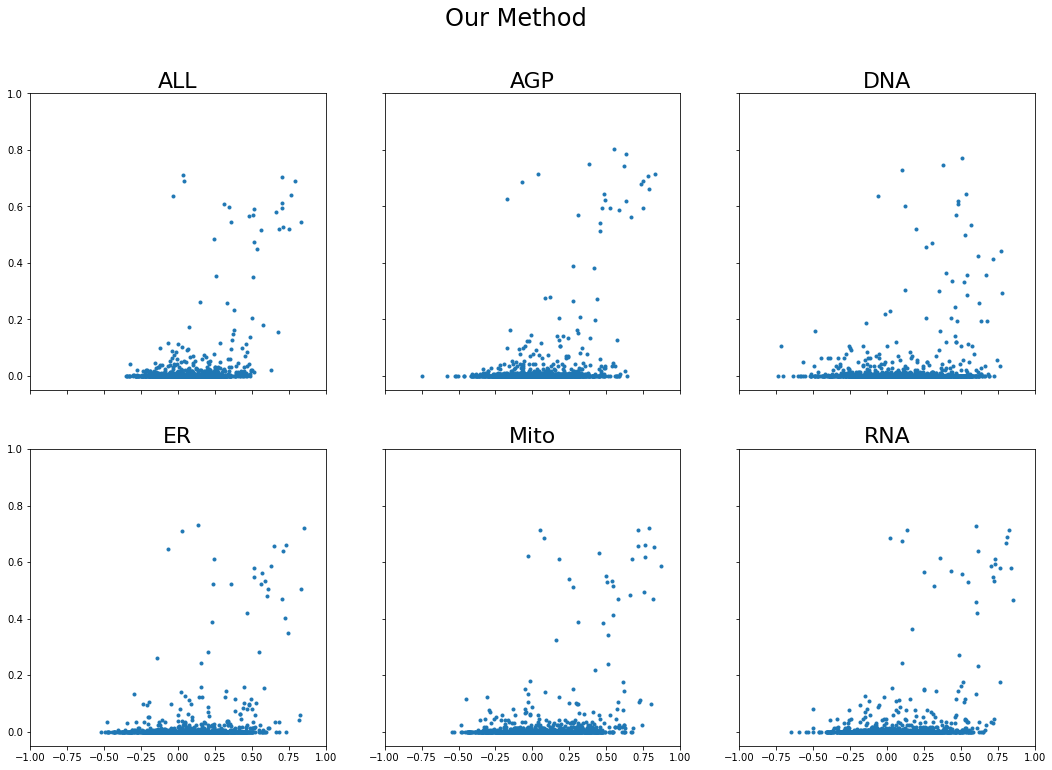

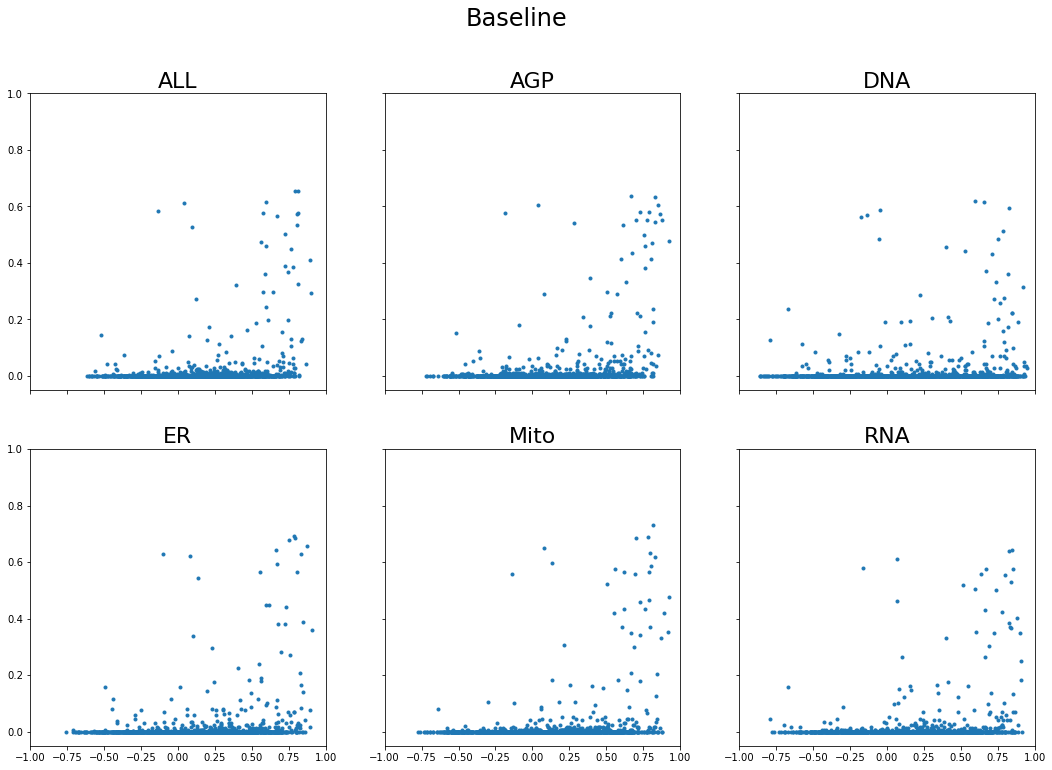

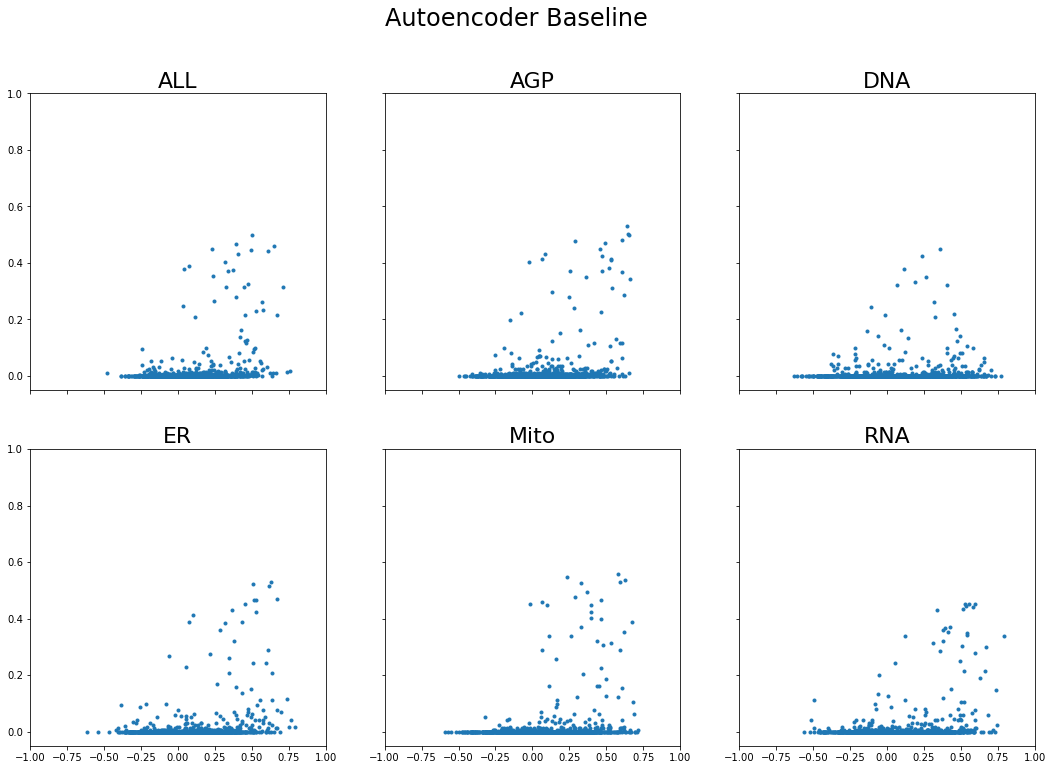

In [63]:
for method, name in zip(['map', 'raw', 'raw1to1'], ['Our Method', 'Baseline', 'Autoencoder Baseline']):
    
    ncols=3
    fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(ncols*6, 2*6), sharey=True, sharex=True)
    fig.suptitle(name, fontsize=24)

    for i, chan in enumerate(cols_dict.keys()):
        ax = axs[i//ncols, i%ncols]
        ax.plot(result_per_chan[f'{chan}_{method}_corr'], result_per_chan[f'{chan}_{method}_hit'], '.')
#         _ = ax.plot([-1,1], [-1,1], 'r:')
        ax.set_title(chan, fontsize=22)
        ax.set_xlim([-1,1])
        ax.set_ylim([-0.05,1])


In [48]:
xedges = [-1, -0.5, -0.25, 0, 0.25, 0.5, 1]
yedges = [0, 0.2, 0.5, 0.8, 1]
# xedges = np.arange(-1,1.1,0.2)
# yedges = np.arange(0,1.01,0.1)

bins = (xedges, yedges)

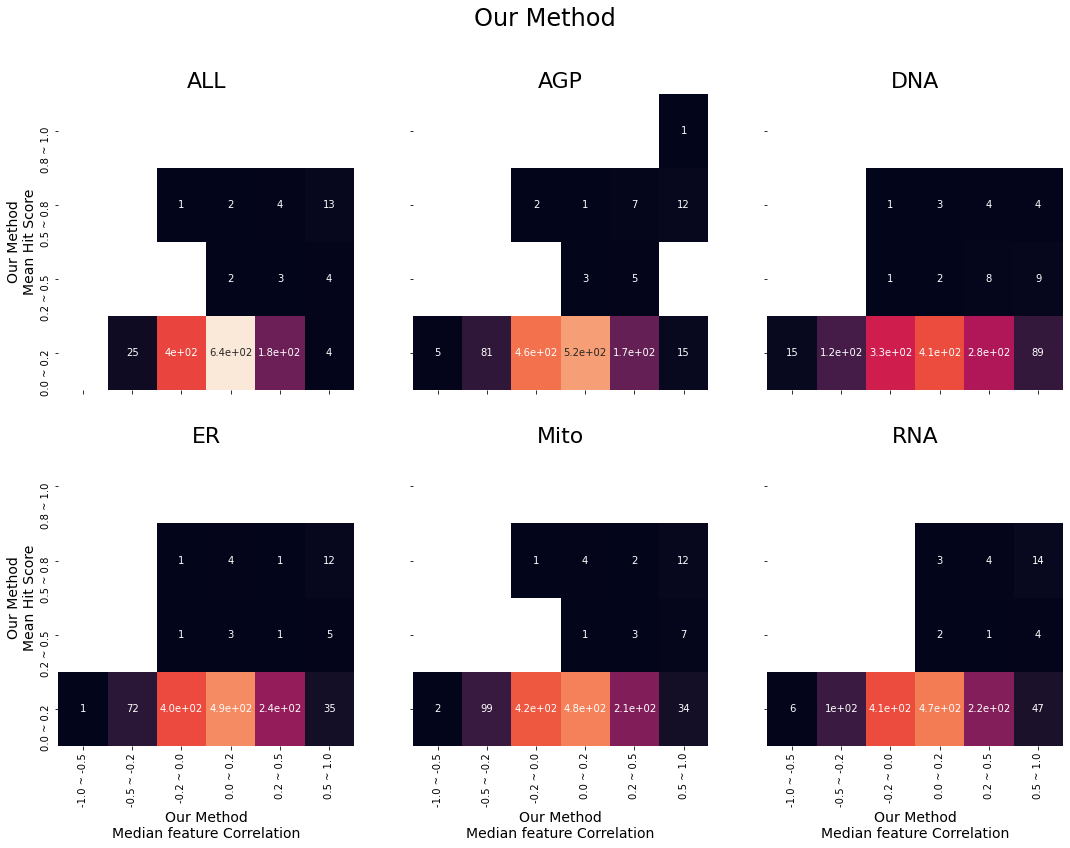

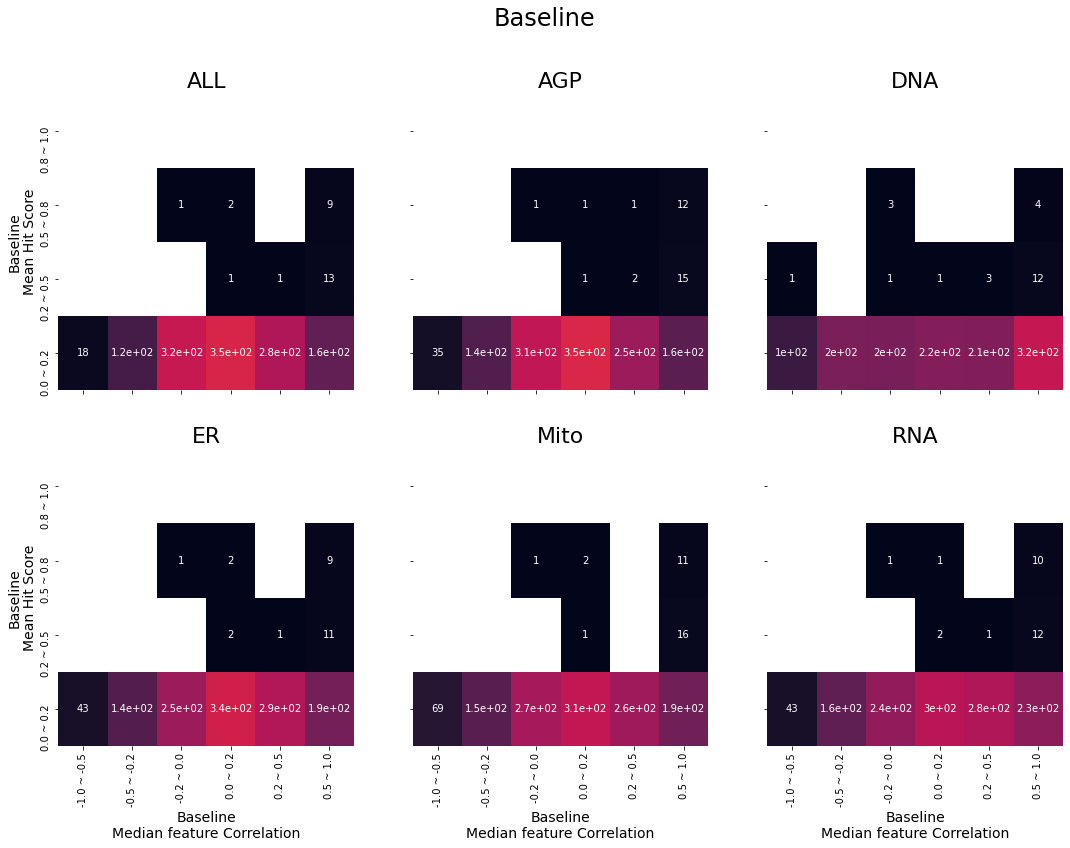

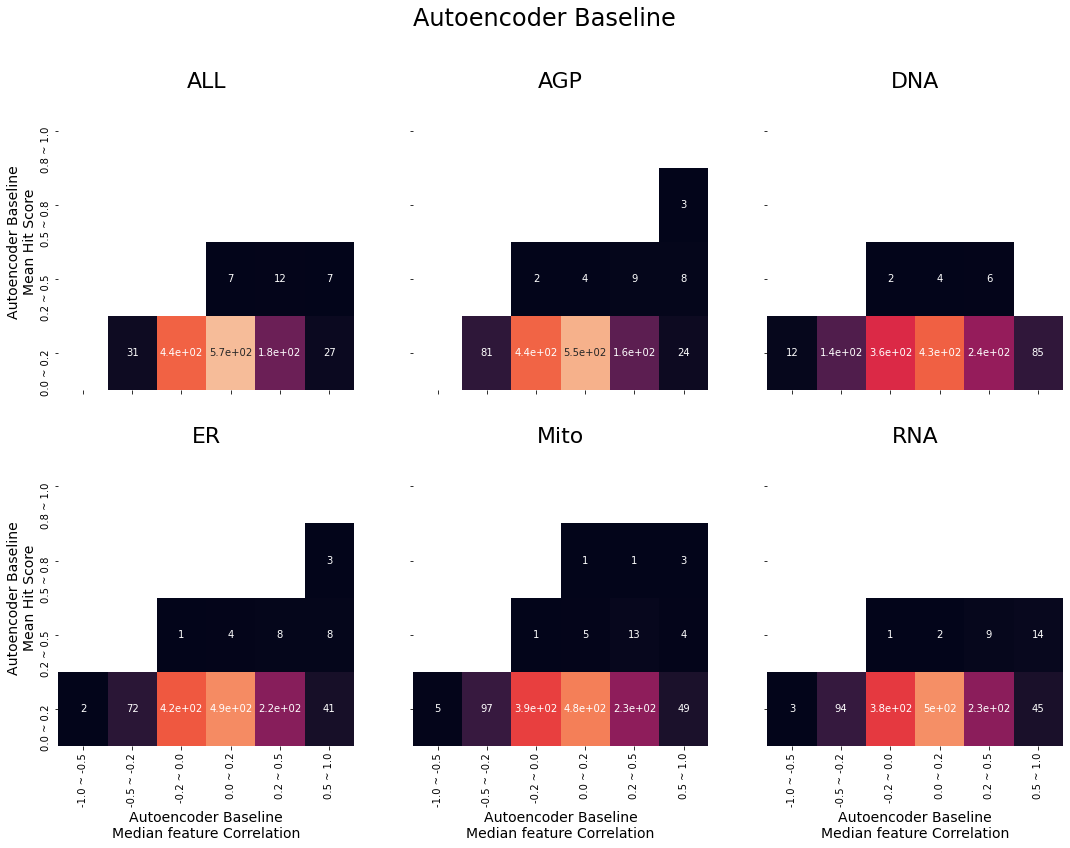

In [64]:
for method, name in zip(['map', 'raw', 'raw1to1'], ['Our Method', 'Baseline', 'Autoencoder Baseline']):
    
    ncols=3
    fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(ncols*6, 2*6), sharey=True, sharex=True)
    fig.suptitle(name, fontsize=24)

    for i, chan in enumerate(cols_dict.keys()):
        ax = axs[i//ncols, i%ncols]
        ax.set_title(chan, fontsize=22)
        
        H, xedges, yedges = np.histogram2d(x=result_per_chan[f'{chan}_{method}_corr'], y=result_per_chan[f'{chan}_{method}_hit'], bins=bins)
        _ = sns.heatmap(np.flip(H.T,axis=0),
                    annot=True,
                    xticklabels=[f'{l1:.1f} ~ {l2:.1f}' for l1, l2 in zip(xedges, xedges[1:])],
                    yticklabels=[f'{l1:.1f} ~ {l2:.1f}' for l2, l1 in zip(np.flip(yedges), np.flip(yedges)[1:])],
                    mask = np.flip(H.T,axis=0)==0,
                        cbar=False,
                        vmax=650,
                   ax=ax)
        if i//ncols:
            _ = ax.set_xlabel(f'{name}\nMedian feature Correlation', fontsize=14)
        if not i%ncols:
            _ = ax.set_ylabel(f'{name}\nMean Hit Score', fontsize=14)
